In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("darkgrid")

from math import sqrt, pi

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML

## Functions 

In [2]:
def prepareData(sklearnDataSet):
    
    X, y = sklearnDataSet(return_X_y=True)
    data  = np.hstack([X,y.reshape(-1,1)])
    cols_name_lst = [f"feature_{i+1}" for i in range(X.shape[1])] + ["target"]
    return pd.DataFrame(data, columns = cols_name_lst)

def gaussian(x, mu, sig):
    aux = 2*(sig**2)
    return np.exp(-(x - mu)**2 /aux)/sqrt(aux)

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0\xa0\xa0"
    display(HTML(output))

## Loading Data 

In [3]:
cancer_df = prepareData(load_breast_cancer)
iris_df = prepareData(load_iris)

In [4]:
#Set the dataset to work with
df = cancer_df

In [5]:
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 42)
display_side_by_side([df_train.head(3), df_test.head(3)], ["Train", "Test"])
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,target
82,25.220000,24.910000,171.500000,1878.000000,0.106300,0.266500,0.333900,0.184500,0.182900,0.067820,0.897300,1.474000,7.382000,120.000000,0.008166,0.056930,0.057300,0.020300,0.010650,0.005893,30.000000,33.620000,211.700000,2562.000000,0.157300,0.607600,0.647600,0.286700,0.235500,0.105100,0.000000
39,13.480000,20.820000,88.400000,559.200000,0.101600,0.125500,0.106300,0.054390,0.172000,0.064190,0.213000,0.591400,1.545000,18.520000,0.005367,0.022390,0.030490,0.012620,0.013770,0.003187,15.530000,26.020000,107.300000,740.400000,0.161000,0.422500,0.503000,0.225800,0.280700,0.107100,0.000000
271,11.290000,13.040000,72.230000,388.000000,0.098340,0.076080,0.032650,0.027550,0.176900,0.062700,0.190400,0.529300,1.164000,13.170000,0.006472,0.011220,0.012820,0.008849,0.016920,0.002817,12.320000,16.180000,78.270000,457.500000,0.135800,0.150700,0.127500,0.087500,0.273300,0.080220,1.000000
,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,target
204,12.470000,18.600000,81.090000,481.900000,0.099650,0.105800,0.080050,0.038210,0.192500,0.063730,0.396100,1.044000,2.497000,30.290000,0.006953,0.019110,0.027010,0.010370,0.017820,0.003586,14.970000,24.640000,96.050000,677.900000,0.142600,0.237800,0.267100,0.101500,0.301400,0.087500,1.000000
70,18.940000,21.310000,123.600000,1130.000000,0.090090,0.102900,0.108000,0.079510,0.158200,0.054610,0.788800,0.797500,5.486000,96.050000,0.004444,0.016520,0.022690,0.013700,0.013860,0.001698,24.860000,26.580000,165.900000,1866.000000,0.119300,0.233600,0.268700,0.178900,0.255100,0.065890,0.000000
131,15.460000,19.480000,101.700000,748.900000,0.109200,0.122300,0.146600,0.080870,0.193100,0.057960,0.474300,0.785900,3.094000,48.310000,0.006240,0.014840,0.028130,0.010930,0.013970,0.002461,19.260000,26.000000,124.900000,1156.000000,0.154600,0.239400,0.379100,0.151400,0.283700,0.080190,0.000000


## Theory 

We want to calculate the probability of Y given a set of features:

$$
P(y|x_1, ..., x_n) = \frac{P(y)P(x_1, ..., x_n|y)}{P(x_1, ..., x_n)}\\
$$

Using the assumption of conditional independence between every pair of features:

$$
P(y|x_1, ..., x_n) = \frac{P(y)\prod_{i=1}^{n}P(x_i|y)}{P(x_1, ..., x_n)}\\
$$

Since $P(x_1, ..., x_n)$ is constant given the input, we can use the following classification rule:

$$
P(y|x_1, ..., x_n) \propto P(y)\prod_{i=1}^{n}P(x_i|y) \\
$$

## Gaussian Naive Bayes 

**Assumption:** The variables exhibit a Gaussian probability distribution.

### Get ```mean``` and ```standard deviation```

In [6]:
def getStats(df):
    
    classes = list(map(int, df.target.unique()))
    return df.groupby("target")\
             .agg(["mean","std"]).T\
             .reset_index()\
             .rename(columns = {"level_0":"feature","level_1":"statistic"})\
             .pivot(index='feature', columns="statistic", values=classes)\
             .T
    
stats_df = getStats(df_train)
stats_df

feature      feature_1  feature_10  feature_11  feature_12  feature_13  \
  statistic                                                              
0 mean       17.420872    0.062737    0.609829    1.215447    4.330641   
  std         3.269915    0.007754    0.356119    0.477792    2.645414   
1 mean       12.173842    0.062783    0.282373    1.213736    1.997480   
  std         1.793027    0.006781    0.109341    0.590460    0.755719   

feature      feature_14  feature_15  feature_16  feature_17  feature_18  ...  \
  statistic                                                              ...   
0 mean        72.936974    0.006853    0.032492    0.042392    0.015244  ...   
  std         63.539832    0.002948    0.018570    0.021943    0.005650  ...   
1 mean        21.117729    0.007109    0.021545    0.026549    0.009859  ...   
  std          8.771352    0.003022    0.016937    0.034392    0.005747  ...   

feature      feature_28  feature_29   feature_3  feature_30   feature_4  \
  statistic                                                               
0 mean         0.182564    0.325534  115.079128    0.091672  975.335897   
  std          0.046398    0.076391   22.250138    0.021871  376.680538   
1 mean         0.074579    0.269338   78.248265    0.079526  465.089590   
  std          0.036329    0.041295   11.894030    0.014060  135.785508   

feature      feature_5  feature_6  feature_7  feature_8  feature_9  
  statistic                                                         
0 mean        0.102842   0.145239   0.160762   0.087377   0.193436  
  std         0.012760   0.054032   0.074483   0.033938   0.027937  
1 mean        0.091880   0.079642   0.046449   0.025466   0.173081  
  std         0.013062   0.034333   0.044886   0.015716   0.024648  

[4 rows x 30 columns]

### Get ```prior probability``` 

In [7]:
#prior probability
evaluate_df = df["target"]\
                .value_counts(normalize=True)\
                .reset_index(name="prior_probability")\
                .rename(columns = {"index":"class"})\
                .set_index("class")
evaluate_df

,prior_probability
class,
1.0,0.627417
0.0,0.372583


### Plotting 

**Gaussian equation**:
    
$$
P(X_i | y) = \frac{1}{\sqrt{2\pi\sigma_y^{2}}}\exp{\frac{-(x_i - \mu_y)^{2}}{2\sigma_y^{2}}}
$$

In [8]:
stats_df.index = map(lambda x: '_'.join(map(str,x)), stats_df.index)
stats_df = stats_df[sorted(stats_df.columns, key=lambda x: int(x.split('_')[1]))]

In [27]:
def gaussian_plot(s, point):
    
    fig = plt.figure(figsize=(20,4))
    mean_lst = []
    std_lst = []
    
    feature_point = point[s.name]
    
    #Split column in means and standard deviations
    for mean, std in zip(s[0::2],s[1::2]):
        mean_lst.append(mean)
        std_lst.append(std)

    max_mean = max(mean_lst)
    min_mean = min(mean_lst)
    max_std  = max(std_lst)  
    
    #Make x axis 
    x = np.linspace(min(mean_lst)-3*max_std, max(mean_lst)+3*max_std, 5000)
    
    #Store likelihood for every class
    y_probability = []
    
    for index, stats in enumerate(zip(mean_lst, std_lst)):
        
        mean, std = stats
        
        y = [gaussian(i, mean, std) for i in x]
        plt.title(fr"PDF: {s.name.upper()}")
        plt.plot(x, y, lw=2,label=fr"$\mu: {round(mean,2)} , \sigma: {round(std,2)}$")
        
        # Calculate likelihood for an given point
        y_point = gaussian(feature_point, mean, std)
        #Store the log to prevent underflow while multiplicating
        y_probability.append(np.log(y_point))
        plt.vlines(x=feature_point, ymin=0, ymax = y_point, linewidth=1, color='k', linestyles = "dashdot")
        plt.hlines(y=y_point, xmin=x[0], xmax = feature_point, linewidth=1, color='k', linestyles = "dashdot")
        
    first_legend = plt.legend(loc="upper left", title=r"Stats", fancybox=True, fontsize=16)
    plt.setp(first_legend.get_title(),fontsize=18)
    plt.gca().add_artist(first_legend)
    
    second_legend = plt.legend(list(range(len(s)//2)),
                               title="Classes",
                               fancybox=True, 
                               fontsize=16,
                               loc='upper right')    
    
    plt.setp(second_legend.get_title(),fontsize=18)       
    plt.show()
    plt.close()
    
    return pd.Series(y_probability)

### Choose an example 

In [28]:
select_id = 15
point = df_test.iloc[select_id].to_dict()
print(f"The Class is: {df_test.iloc[select_id,-1]}")

The Class is: 0.0


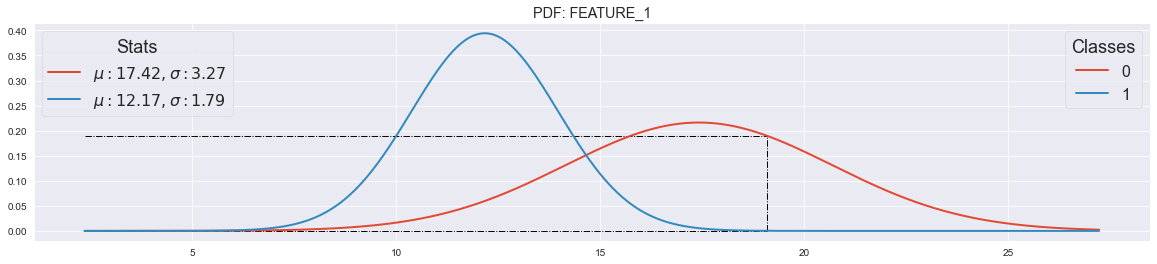

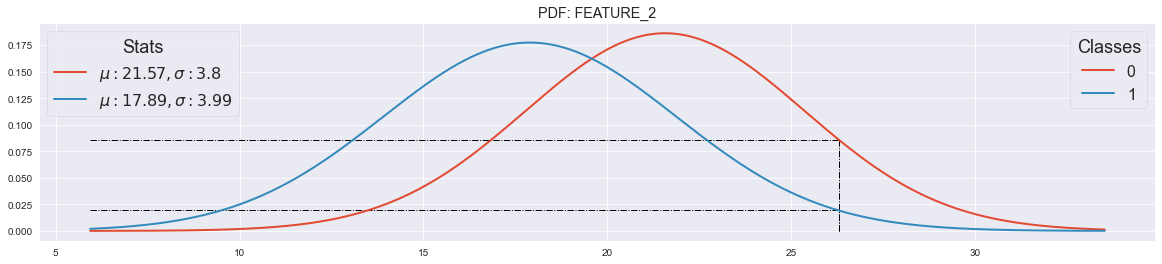

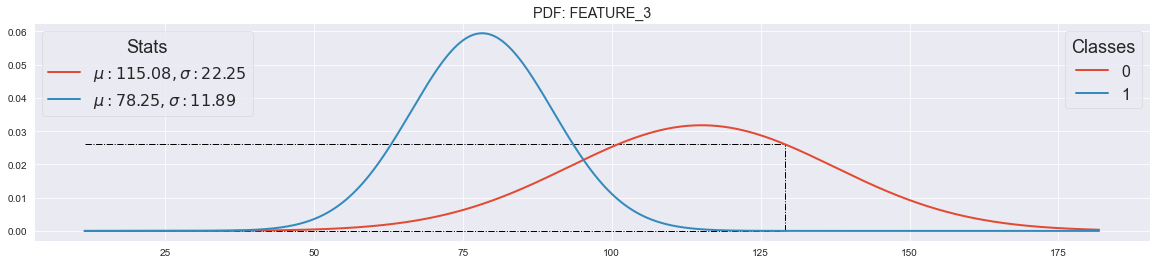

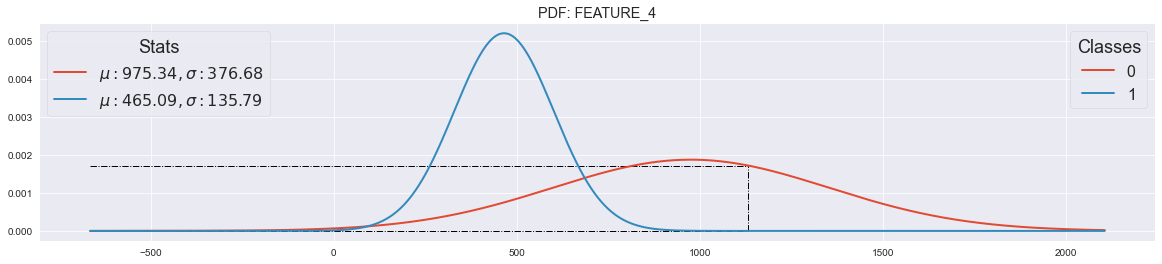

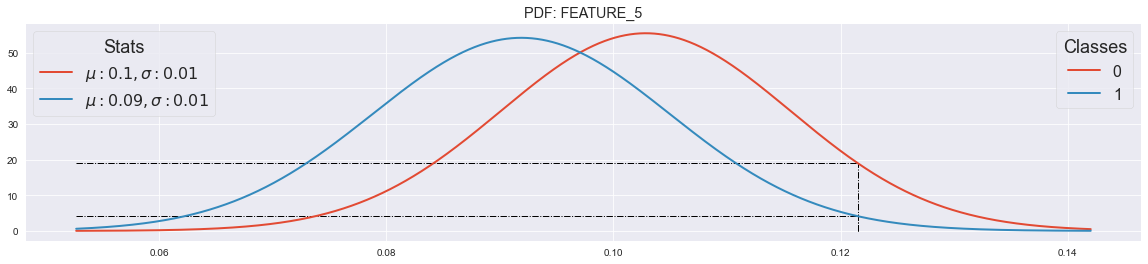

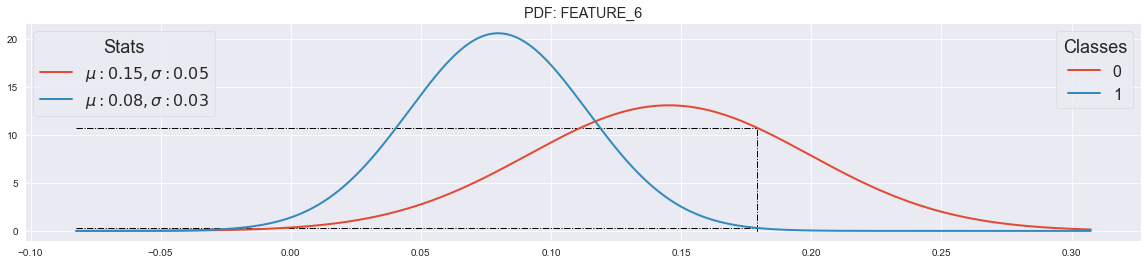

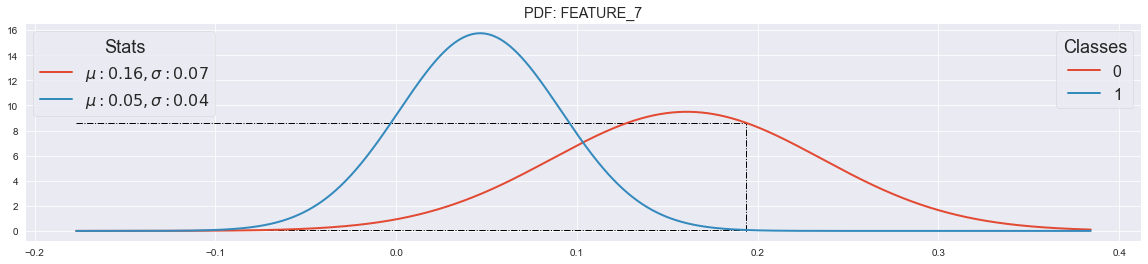

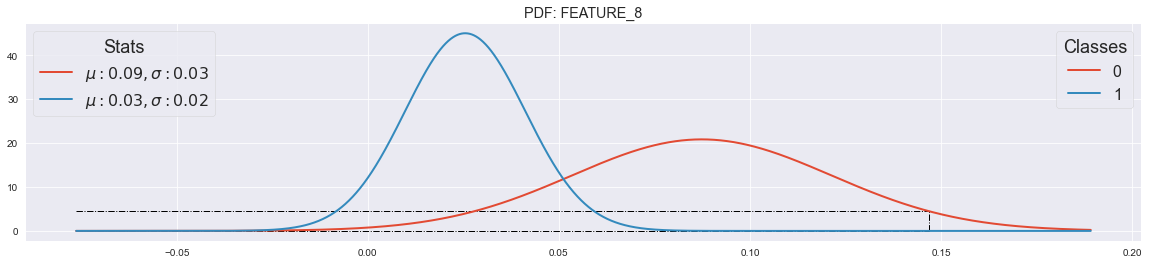

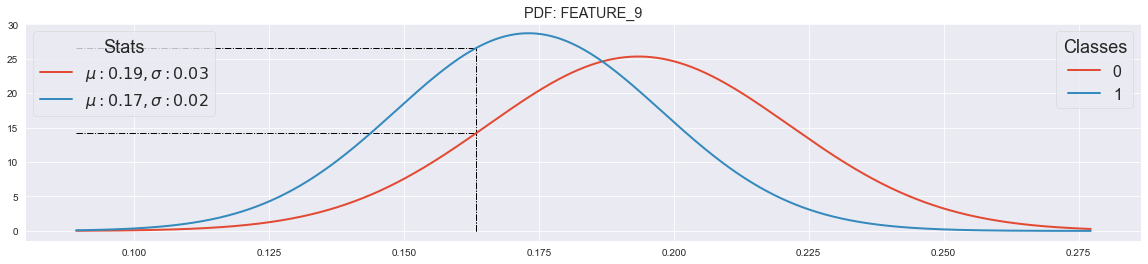

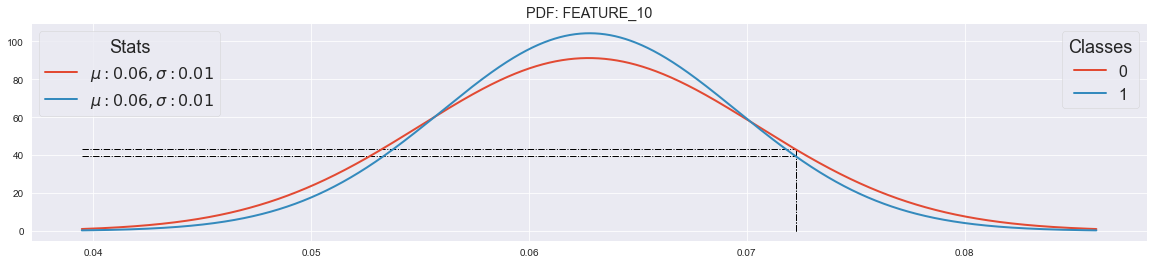

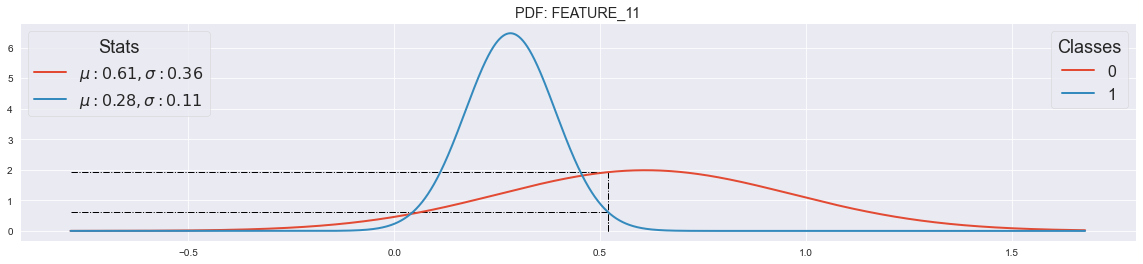

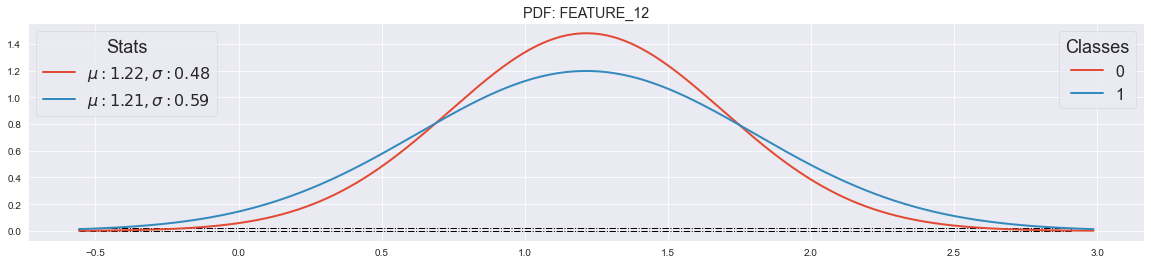

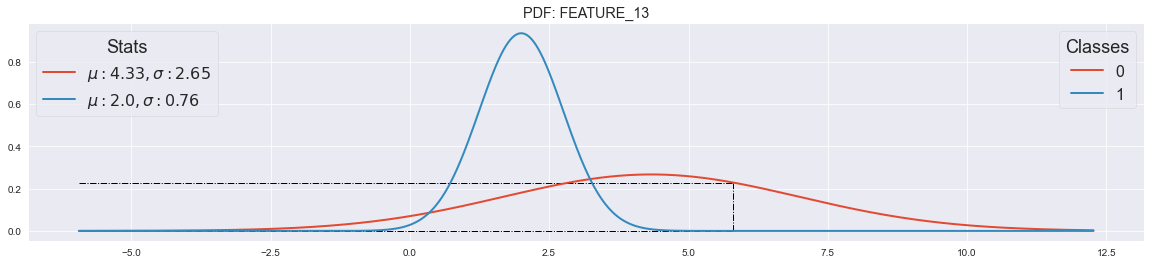

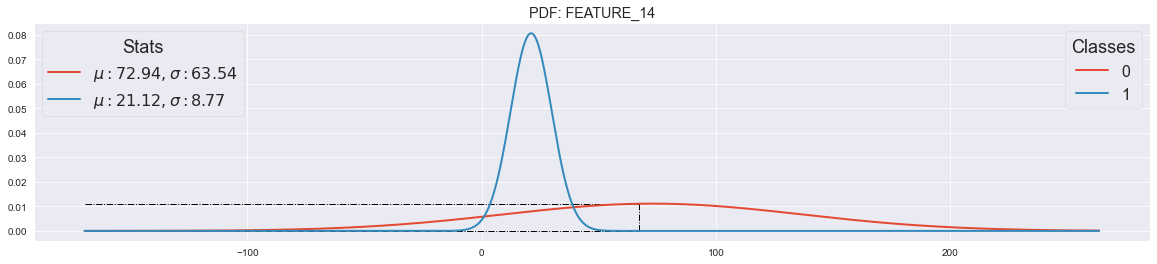

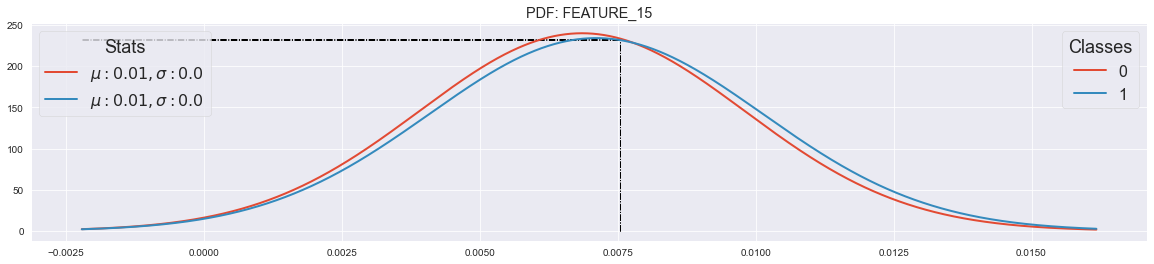

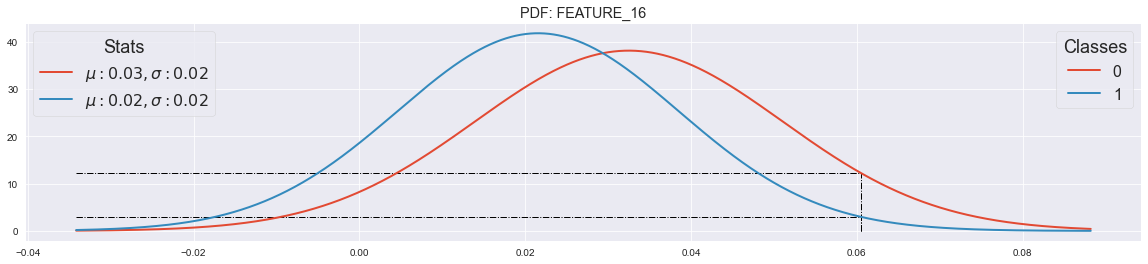

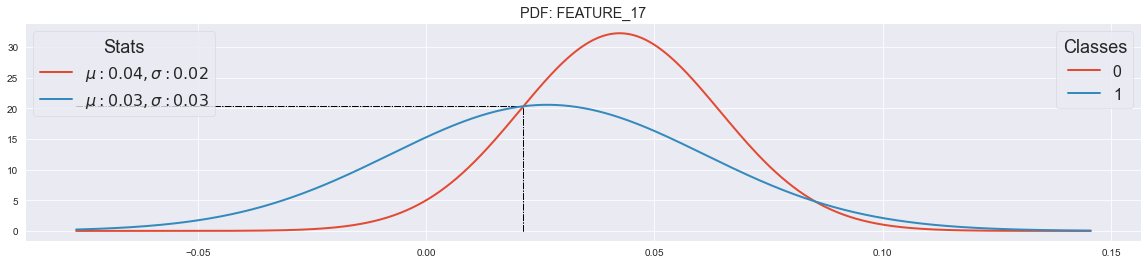

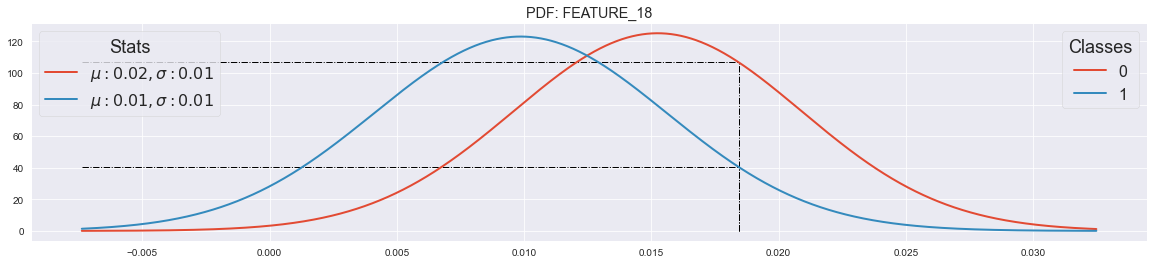

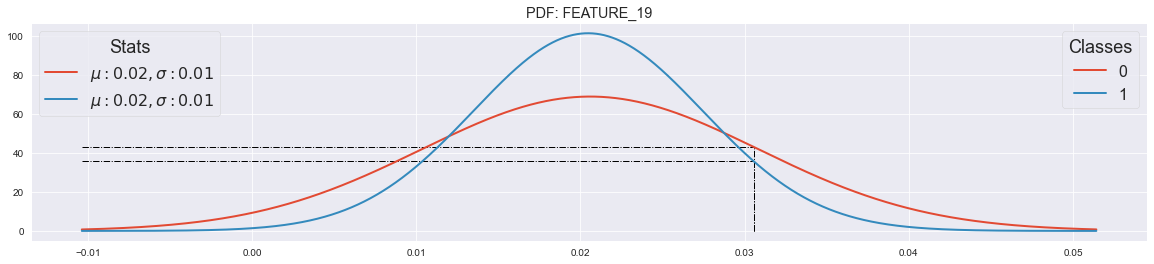

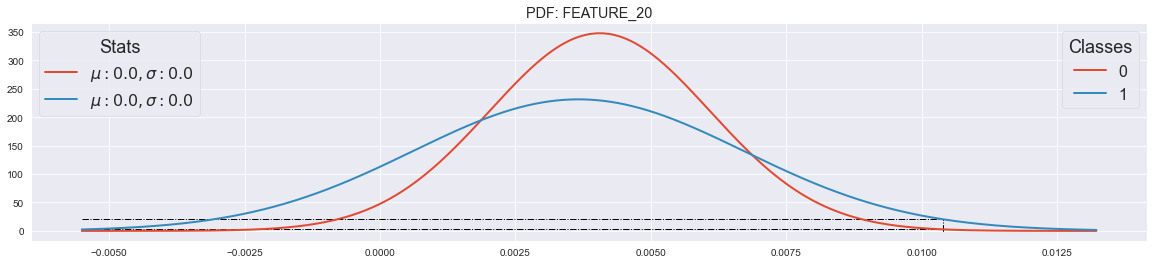

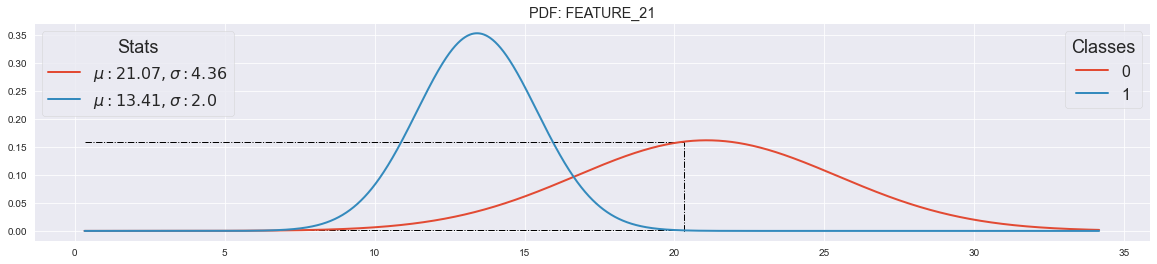

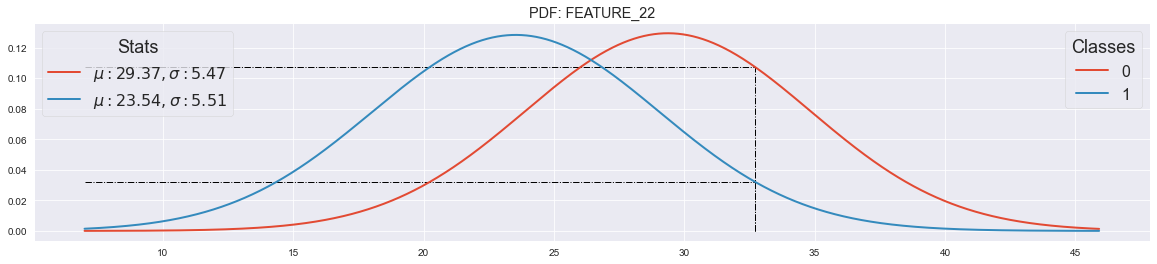

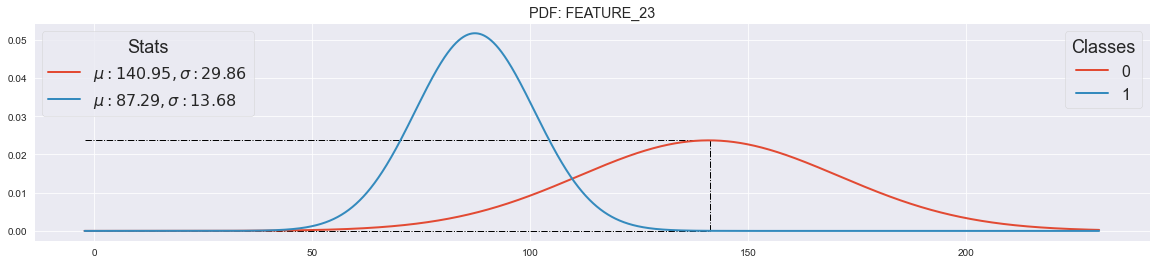

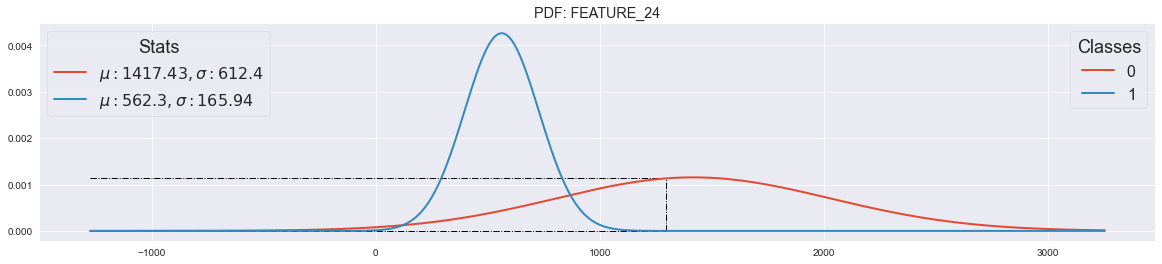

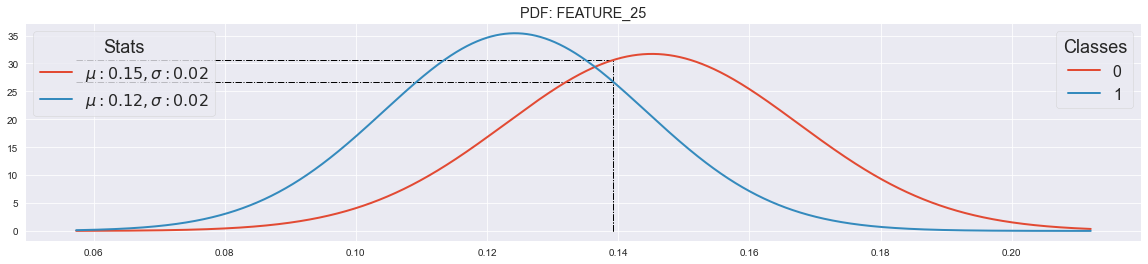

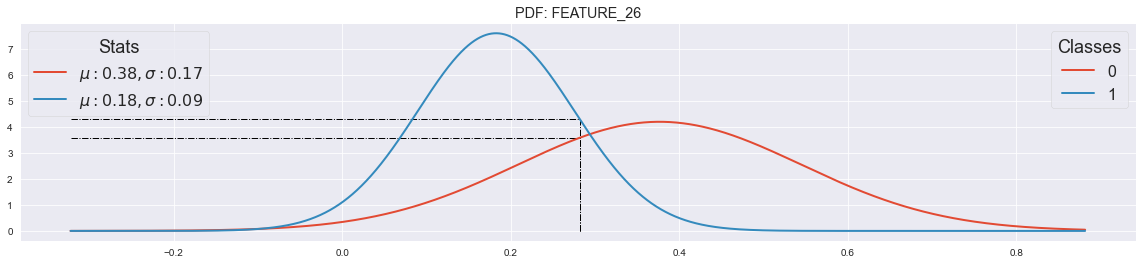

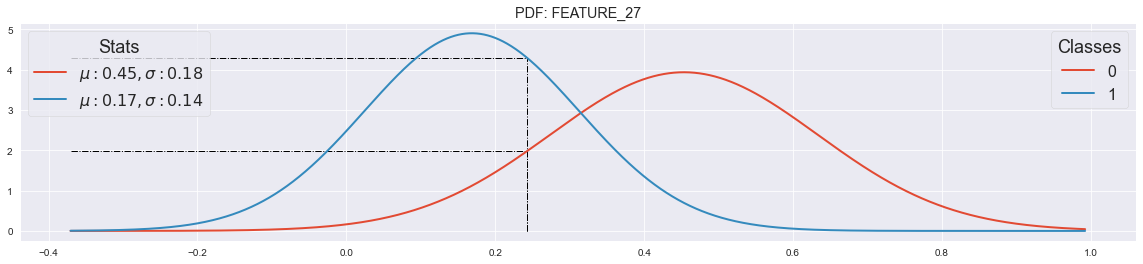

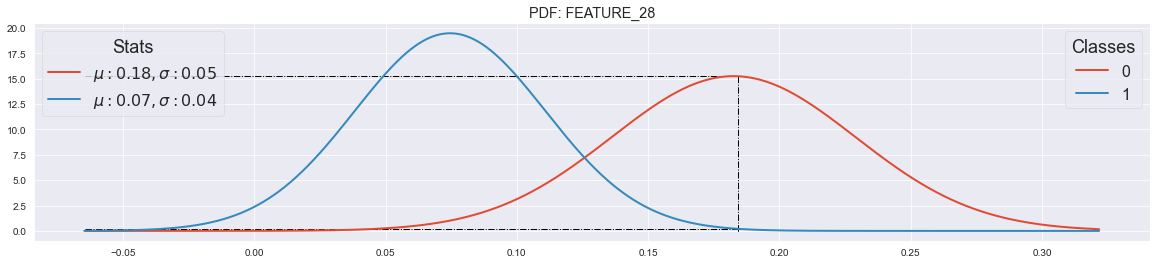

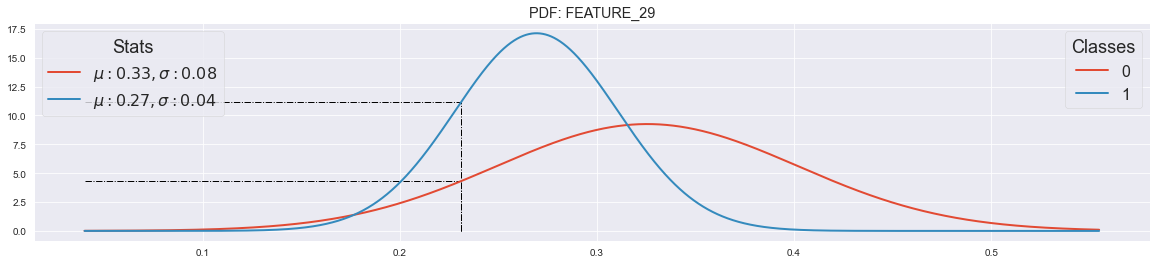

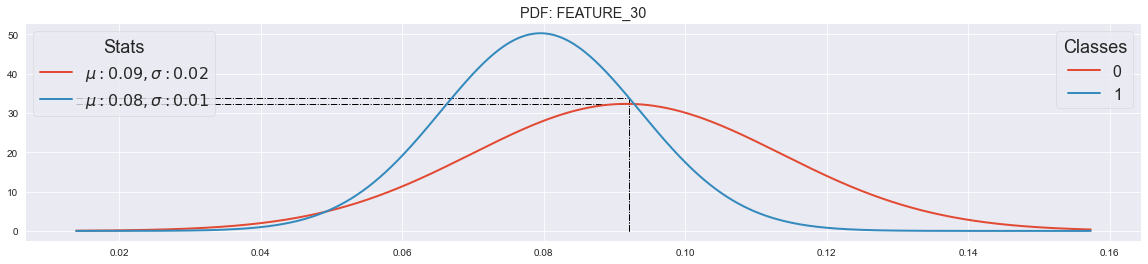

In [29]:
result = stats_df.apply(gaussian_plot, args=[point], result_type = "expand")
result.index.name = "class"

In [30]:
final_stats = pd.concat([evaluate_df,result],axis=1)

In [31]:
final_stats

,prior_probability,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
class,,,,,,,,,,,,,,,,,,,,,
0.0,0.372583,-1.663183,-2.452509,-3.647465,-6.364460,2.945793,2.375242,2.152829,1.498576,2.653261,...,-1.834559,-2.233150,-3.743034,-6.782980,3.421051,1.276282,0.686209,2.723382,1.461230,3.475879
1.0,0.627417,-8.391205,-3.947331,-11.962133,-17.319062,1.420321,-1.170799,-2.623972,-26.043261,3.279348,...,-7.013403,-3.440802,-10.759150,-15.286778,3.286748,1.461631,1.455502,-1.575597,2.411724,3.522407


In [32]:
def test(x):
    acc = 1
    for i in x:
        acc += i
    return acc
        

final_stats.apply(test,axis=1)

class
0.0     10.261451
1.0   -100.969790
dtype: float64